In [6]:
!pip install gym
!pip install numpy


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


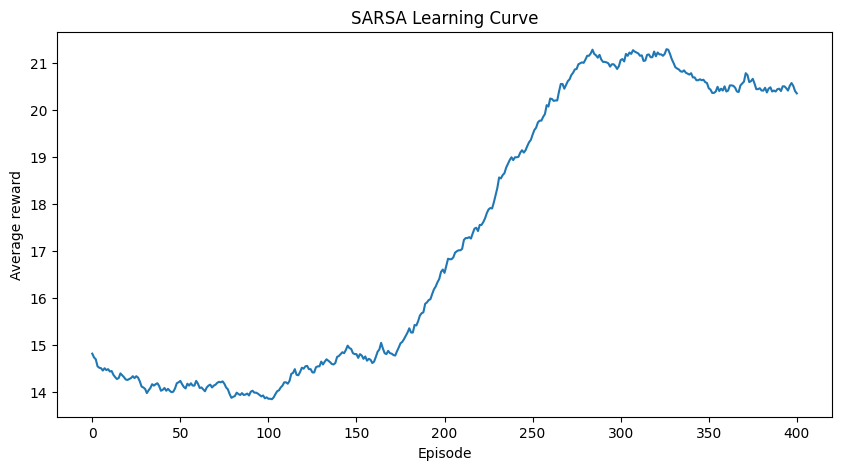

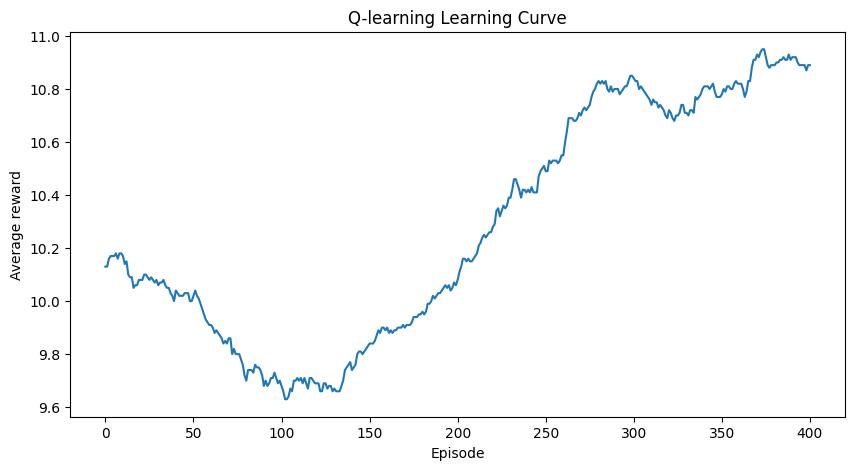

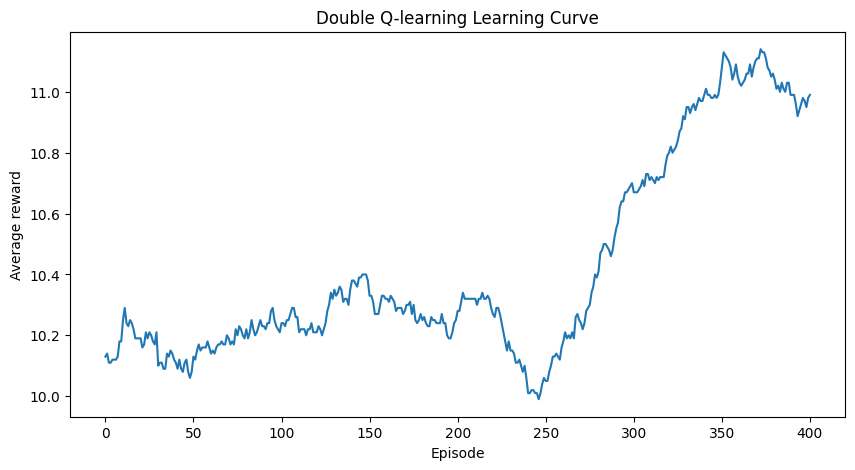

In [9]:
import gym
import numpy as np
import matplotlib.pyplot as plt

env = gym.make('CartPole-v1')

# Дискретизация состояний
def discretize_state(state, bins):
    state_indices = []
    for i in range(len(state)):
        state_indices.append(np.digitize(state[i], bins[i]) - 1)
    return tuple(state_indices)

# Создание биннингов для каждого состояния
def create_bins(num_bins):
    bins = [
        np.linspace(-4.8, 4.8, num_bins),   # Cart position
        np.linspace(-4, 4, num_bins),       # Cart velocity
        np.linspace(-0.418, 0.418, num_bins), # Pole angle
        np.linspace(-4, 4, num_bins)        # Pole angular velocity
    ]
    return bins

def choose_action(state, q_table, epsilon):
    if np.random.uniform(0, 1) < epsilon:
        return env.action_space.sample()
    else:
        return np.argmax(q_table[state])

def plot_learning_curve(rewards, title):
    plt.figure(figsize=(10, 5))
    plt.plot(np.convolve(rewards, np.ones(100)/100, mode='valid'))
    plt.xlabel('Episode')
    plt.ylabel('Average reward')
    plt.title(title)
    plt.show()

def sarsa(env, num_episodes, alpha, gamma, epsilon, bins):
    n_actions = env.action_space.n
    q_table = np.zeros((len(bins[0]), len(bins[1]), len(bins[2]), len(bins[3]), n_actions))
    rewards = []

    for episode in range(num_episodes):
        state = discretize_state(env.reset(), bins)
        action = choose_action(state, q_table, epsilon)
        total_reward = 0

        while True:
            next_state, reward, done, _ = env.step(action)
            next_state = discretize_state(next_state, bins)
            next_action = choose_action(next_state, q_table, epsilon)

            q_table[state + (action,)] += alpha * (reward + gamma * q_table[next_state + (next_action,)] - q_table[state + (action,)])

            state, action = next_state, next_action
            total_reward += reward

            if done:
                break

        rewards.append(total_reward)

    return q_table, rewards

def q_learning(env, num_episodes, alpha, gamma, epsilon, bins):
    n_actions = env.action_space.n
    q_table = np.zeros((len(bins[0]), len(bins[1]), len(bins[2]), len(bins[3]), n_actions))
    rewards = []

    for episode in range(num_episodes):
        state = discretize_state(env.reset(), bins)
        total_reward = 0

        while True:
            action = choose_action(state, q_table, epsilon)
            next_state, reward, done, _ = env.step(action)
            next_state = discretize_state(next_state, bins)

            q_table[state + (action,)] += alpha * (reward + gamma * np.max(q_table[next_state]) - q_table[state + (action,)])

            state = next_state
            total_reward += reward

            if done:
                break

        rewards.append(total_reward)

    return q_table, rewards

def double_q_learning(env, num_episodes, alpha, gamma, epsilon, bins):
    n_actions = env.action_space.n
    q_table1 = np.zeros((len(bins[0]), len(bins[1]), len(bins[2]), len(bins[3]), n_actions))
    q_table2 = np.zeros((len(bins[0]), len(bins[1]), len(bins[2]), len(bins[3]), n_actions))
    rewards = []

    for episode in range(num_episodes):
        state = discretize_state(env.reset(), bins)
        total_reward = 0

        while True:
            action = choose_action(state, q_table1 + q_table2, epsilon)
            next_state, reward, done, _ = env.step(action)
            next_state = discretize_state(next_state, bins)

            if np.random.rand() < 0.5:
                best_next_action = np.argmax(q_table1[next_state])
                q_table1[state + (action,)] += alpha * (reward + gamma * q_table2[next_state + (best_next_action,)] - q_table1[state + (action,)])
            else:
                best_next_action = np.argmax(q_table2[next_state])
                q_table2[state + (action,)] += alpha * (reward + gamma * q_table1[next_state + (best_next_action,)] - q_table2[state + (action,)])

            state = next_state
            total_reward += reward

            if done:
                break

        rewards.append(total_reward)

    return q_table1, q_table2, rewards

# Параметры обучения
num_episodes = 500
alpha = 0.1
gamma = 0.99
epsilon = 0.1
num_bins = 10
bins = create_bins(num_bins)

# SARSA
q_table_sarsa, rewards_sarsa = sarsa(env, num_episodes, alpha, gamma, epsilon, bins)
plot_learning_curve(rewards_sarsa, 'SARSA Learning Curve')

# Q-learning
q_table_q_learning, rewards_q_learning = q_learning(env, num_episodes, alpha, gamma, epsilon, bins)
plot_learning_curve(rewards_q_learning, 'Q-learning Learning Curve')

# Double Q-learning
q_table1_double_q_learning, q_table2_double_q_learning, rewards_double_q_learning = double_q_learning(env, num_episodes, alpha, gamma, epsilon, bins)
plot_learning_curve(rewards_double_q_learning, 'Double Q-learning Learning Curve')
